In [1]:
import dill
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import sys
sys.path.append(os.path.abspath('..'))
from ethan.numpy.net import *

In [2]:
from torchvision import datasets

mnist_dir = "/opt/data/MNIST/raw/"
datasets.MNIST(root="/opt/data", train=True, download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /opt/data
    Split: Train

In [3]:
# 用于适配interview接口
class MNIST_Net(Net):
    @staticmethod
    def one_hot(labels, num_classes):
        one_hot_labels = np.zeros((len(labels), num_classes))
        for i in range(len(labels)):
            one_hot_labels[i, labels[i]] = 1
        return one_hot_labels

    def interview(self, eval_datafile_path):
        eval_images = self.image_data(eval_datafile_path[0])
        eval_labels = self.label_data(eval_datafile_path[1])
        eval_labels = self.one_hot(eval_labels, 10)
        _eval_labels = self.pred(eval_images)
        return np.mean(np.argmax(eval_labels, axis=1) == np.argmax(_eval_labels, axis=1)) * 100

(60000, 28, 28) (60000,)


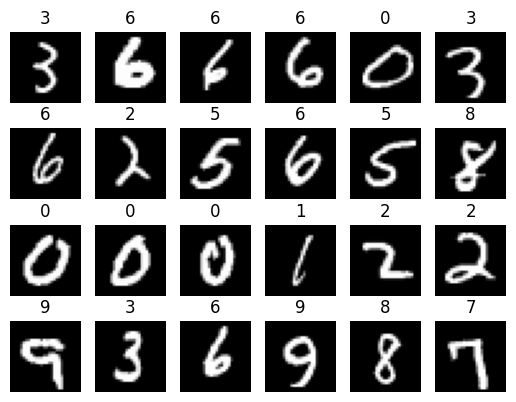

In [4]:
# 读取文件数据
images = idx2numpy.convert_from_file(mnist_dir + "train-images-idx3-ubyte")
labels = idx2numpy.convert_from_file(mnist_dir + "train-labels-idx1-ubyte")
print(images.shape, labels.shape)

# 随机打乱数据
np.random.seed(0)
indices = np.random.permutation(len(images))
images = images[indices]
labels = labels[indices]

for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(labels[i])
    plt.axis("off")
plt.show()

In [5]:
# 分割训练集与验证集 (4:1)
split = int(len(images) * 0.8)
train_images, valid_images = images[:split], images[split:]
train_labels, valid_labels = labels[:split], labels[split:]

In [6]:
# 添加图片通道
height, width = images.shape[1], images.shape[2]
train_images = train_images.reshape(-1, 1, height, width)
valid_images = valid_images.reshape(-1, 1, height, width)

# 独热标签数据
train_labels = MNIST_Net.one_hot(train_labels, 10)
valid_labels = MNIST_Net.one_hot(valid_labels, 10)

print(train_images.shape, valid_images.shape)
print(train_labels.shape, valid_labels.shape)

(48000, 1, 28, 28) (12000, 1, 28, 28)
(48000, 10) (12000, 10)


In [7]:
def shuffle_data(images, labels):
    np.random.seed(0)
    indices = np.random.permutation(len(images))
    return images[indices], labels[indices]

In [8]:
net = MNIST_Net([
    {"module": Flatten},
    {"module": Mlp, "param": {"in_features": 784, "out_features": 256}},
    {"module": Relu},
    {"module": Mlp, "param": {"in_features": 256, "out_features": 64}},
    {"module": Relu},
    {"module": Mlp, "param": {"in_features": 64, "out_features": 10}},
])

In [9]:
record = [] # 记录训练过程
epoch_count = 0  # 总训练轮数
best_accuracy = 0  # 最佳准确率
model_path = "task1-mnist.pkl"  # 模型保存路径

batch_size = 512  # 批大小

initial_lr = 1  # 初始学习率
lr_count = 0  # 连续无增长计数
lr_patience = 20  # 学习率容忍次数
lr_factor = 0.5  # 学习率衰减因子

worse_count = 0  # 连续无增长计数
worse_tolerance = 50  # 无增长容忍次数

In [10]:
max_epochs = 400
pbar = tqdm(range(max_epochs))
for i in pbar:
    train_images, train_labels = shuffle_data(train_images, train_labels)
    net.train(train_images, train_labels, Mse, batch_size, initial_lr)

    _train_labels = net.pred(train_images)
    _valid_labels = net.pred(valid_images)
    _train_loss = Mse.forward(train_labels, _train_labels)
    _valid_loss = Mse.forward(valid_labels, _valid_labels)
    _valid_accuracy = np.mean(np.argmax(_valid_labels, axis=1) == np.argmax(valid_labels, axis=1)) * 100

    epoch_count += 1
    if _valid_accuracy > best_accuracy:
        lr_count, worse_count = 0, 0
        best_accuracy = _valid_accuracy
        with open(model_path, "wb") as f:
            dill.dump(net, f)
    else:
        lr_count += 1
        worse_count += 1
        if lr_count > lr_patience:
            initial_lr *= lr_factor
            lr_count = 0
        if worse_count > worse_tolerance:
            print(f"模型连续{worse_tolerance}次无提升，提前终止训练")
            break

    pbar.set_postfix(train_loss=_train_loss, valid_loss=_valid_loss, accuracy=f"{_valid_accuracy:.2f}%", best_accuracy=f"{best_accuracy:.2f}%", lr=initial_lr)
    record.append([_train_loss, _valid_loss, _valid_accuracy])

print("模型架构:", net)
print("保存路径:", model_path)
print("最佳训练轮数:", epoch_count - worse_tolerance)
print("最佳准确率:", best_accuracy)

  2%|▏         | 6/400 [00:11<12:22,  1.89s/it, accuracy=92.88%, best_accuracy=92.88%, lr=1, train_loss=0.0183, valid_loss=0.0187]


KeyboardInterrupt: 

In [ ]:
# 绘制训练曲线
# 图1: 训练损失与验证损失
# 图2: 验证准确率
record = np.array(record)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(record[:, 0], label="Train Loss")
plt.plot(record[:, 1], label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(record[:, 2], label="Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
# 打印识别失败的图片
_valid_labels = net.pred(valid_images)
indices = np.argmax(_valid_labels, axis=1) != np.argmax(valid_labels, axis=1)
indices = np.random.permutation(np.where(indices)[0])


# 标题为 (预测-准确)
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(valid_images[indices][i].reshape(28, 28), cmap="gray")
    plt.title(f"{np.argmax(_valid_labels[indices][i])}-[{np.argmax(valid_labels[indices][i])}]")
    plt.axis("off")
plt.show()